In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

import os
import sys

# Determine the absolute path to your training data folder.
project_root = os.path.abspath(
    os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')
)

# Insert project_root to sys.path if needed.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Build the path to the data folder (assuming your data folder is directly under the project root)
data_dir = os.path.join(project_root, 'data')
data_small_dir = os.path.join(project_root, 'data_small')

print("Project root:", project_root)
print("Data directory:", data_dir)

from models import get_model, effnetv2b0_base, effnetv2b3_base,train_model

from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

Project root: /home/phigep/fh/face-mask-detection
Data directory: /home/phigep/fh/face-mask-detection/data


2025-01-26 13:11:47.135892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737893507.147330  270128 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737893507.150982  270128 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 13:11:47.164407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1737893509.342271  270128 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14

In [4]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
test_small_dir = os.path.join(data_small_dir, 'test')
val_dir = os.path.join(data_dir, 'validation')

In [5]:
BATCH_SIZE = 32
ORIGINAL_IMAGE_SIZE = (None, None)  # Allow variable sizes
TARGET_IMAGE_SIZE = (224, 224)       # EfficientNetV2's expected input size
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
from preprocessing import get_augmented_dataset
train_dataset = get_augmented_dataset(train_dir)
test_dataset = get_augmented_dataset(test_dir,batch_size=1,shuffle=False)
test_small_dataset = get_augmented_dataset(test_small_dir,batch_size=1, shuffle=False)
validation_dataset = get_augmented_dataset(val_dir,batch_size=32, shuffle=False)

Found 73230 files belonging to 2 classes.
Found 19343 files belonging to 2 classes.
Found 1132 files belonging to 2 classes.
Found 36545 files belonging to 2 classes.


In [12]:
enetb0_model = get_model(effnetv2b0_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2,classifier_activation="sigmoid", training_base=True)

In [13]:
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=5e-5)

In [14]:
enetb0_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

change back to python to train:

In [15]:
modelname="effnetv2b0notfrozen"
enetb0_model,history = train_model(checkpoint_dir="./checkpoints/",
                                   epochs=3,
                                   model=enetb0_model,
                                   train_data=train_dataset,
                                   val_data=validation_dataset,
                                   modelname=modelname
                                   )

Epoch 1/3
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9920 - loss: 0.0370

2025-01-26 13:20:50.467653: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2428', 144 bytes spill stores, 144 bytes spill loads

2025-01-26 13:20:50.536888: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2428', 520 bytes spill stores, 520 bytes spill loads




Epoch 1: val_loss improved from inf to 0.00211, saving model to ./checkpoints/functional_2.keras
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 211s 73ms/step - accuracy: 0.9920 - loss: 0.0370 - val_accuracy: 0.9995 - val_loss: 0.0021 - learning_rate: 5.0000e-05
Epoch 2/3
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9995 - loss: 0.0018
Epoch 2: val_loss did not improve from 0.00211
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 150s 65ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9995 - val_loss: 0.0022 - learning_rate: 5.0000e-05
Epoch 3/3
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9996 - loss: 0.0014
Epoch 3: val_loss did not improve from 0.00211
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 150s 65ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9989 - val_loss: 0.0054 - learning_rate: 5.0000e-05


In [16]:
from keras.models import load_model
enetb0_model = load_model(f"./checkpoints/{modelname}.keras")

2025-01-26 13:27:25.216509: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


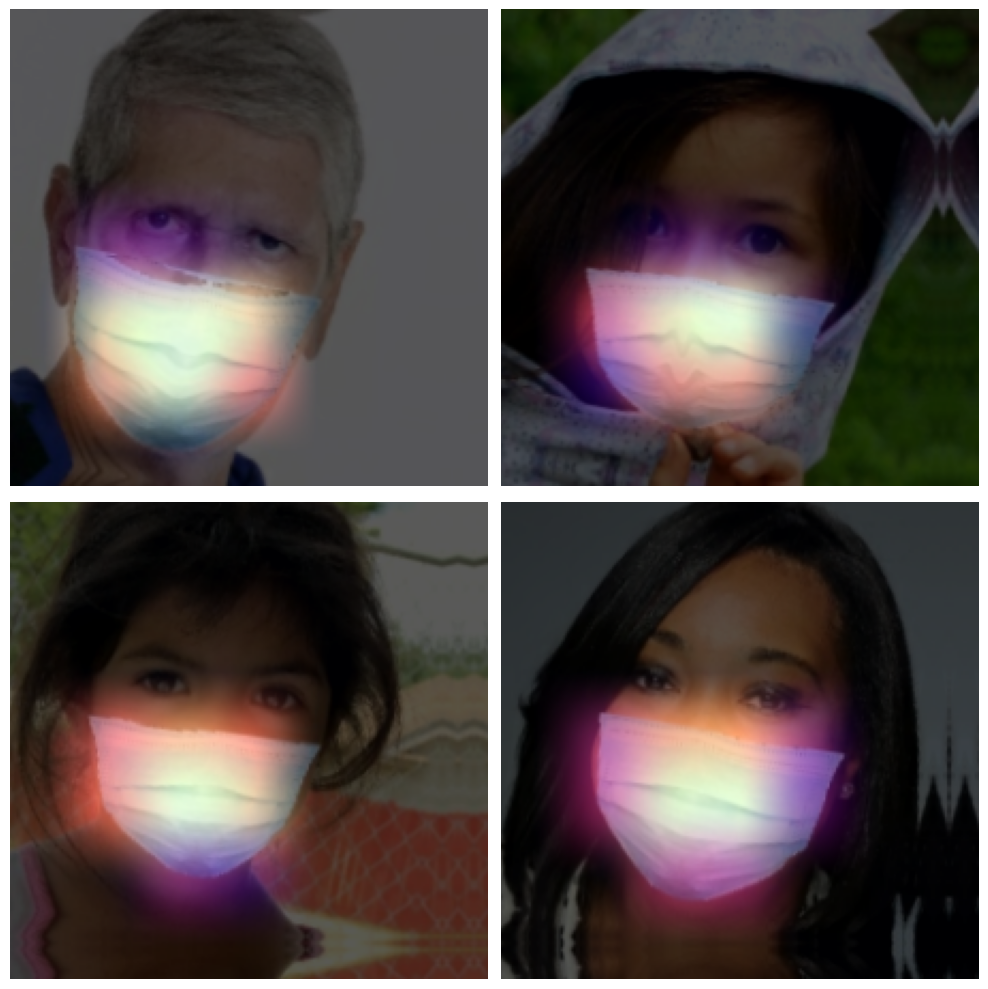

In [17]:
from eval import make_gradcam_heatmap, superimpose_gradcam,plot_images_grid
import matplotlib.pyplot as plt
final_images=[]
for images, labels in test_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0, 0, 0, 0]
[0, 0, 0, 0]


2025-01-26 13:27:37.719449: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


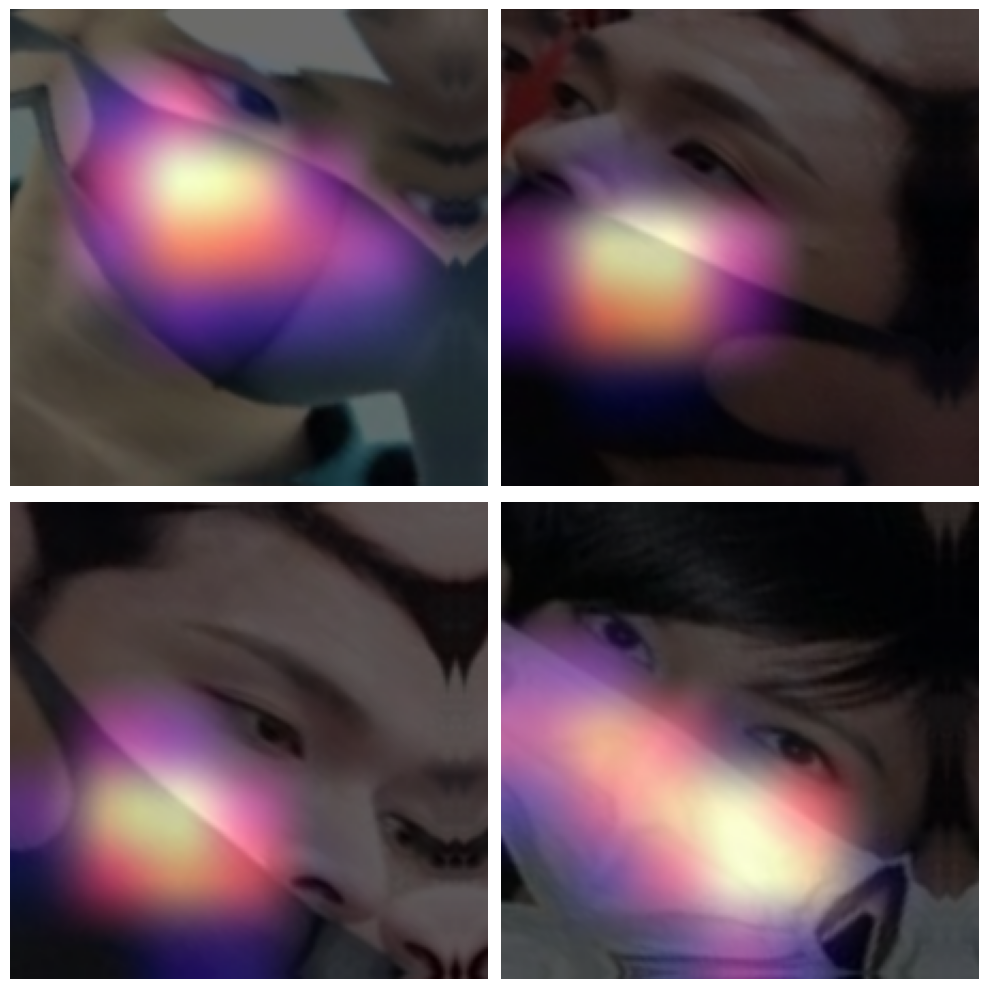

In [18]:
import numpy as np
final_images=[]
preds = []
labels = []
for images, label in test_small_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    pred= enetb0_model.predict(images)
    preds.append(int(np.argmax(pred)))
    labels.append(int(np.argmax(label)))
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)
print(labels)
print(preds)

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report
def create_truncated_viridis():
    """
    Creates a truncated version of the viridis colormap up to dark green.
    
    Returns:
        LinearSegmentedColormap: A new colormap truncated to dark green.
    """
    viridis = plt.cm.get_cmap('viridis')
    
    # Determine the point to truncate the colormap
    # Adjust the trunc_point as needed to capture up to dark green
    trunc_point = 0.5  # Example value; adjust based on visualization
    
    # Generate new colors by sampling the viridis colormap up to trunc_point
    new_colors = viridis(np.linspace(0, trunc_point, 256))
    truncated_viridis = LinearSegmentedColormap.from_list('truncated_viridis', new_colors)
    
    return truncated_viridis
def evaluate_model_seaborn(test_dataset, y_true, y_pred):
    """
    Evaluates the model by computing various metrics and visualizing the confusion matrix using Seaborn.
    
    Args:
        test_dataset (iterable): An iterable of (image, label) tuples.
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
    
    Returns:
        dict: A dictionary containing evaluation metrics.
        list: A list of misclassified images.
    """
    # Generate classification report and metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    
    # Create truncated viridis colormap
    truncated_viridis = create_truncated_viridis()
    
    # Plot confusion matrix using seaborn with truncated viridis colormap
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=truncated_viridis,
                xticklabels=classes, yticklabels=classes,
                cbar=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # Identify misclassified samples
    misclassified = []
    for idx, (image, label) in enumerate(test_dataset):
        true_label = np.argmax(label,axis=1)[0]
        pred = y_pred[idx]
        #print(true_label,pred)
        if true_label != pred:
            misclassified.append([image.numpy(),true_label,pred])
    
    # Compile metrics
    metrics = {
        'accuracy': acc,
        'f1_score': f1,
        'matthews_corrcoef': mcc,
        'classification_report': report
    }
    
    return metrics, misclassified

In [73]:
def get_y_true(test_dataset):
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    return y_true
y_true = get_y_true(test_dataset)
y_true = np.argmax(y_true, axis=1)

In [74]:
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef, confusion_matrix
y_preds= enetb0_model.predict(test_dataset)
y_preds = np.argmax(y_preds, axis=1)

19343/19343 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step


/tmp/ipykernel_270128/941382665.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


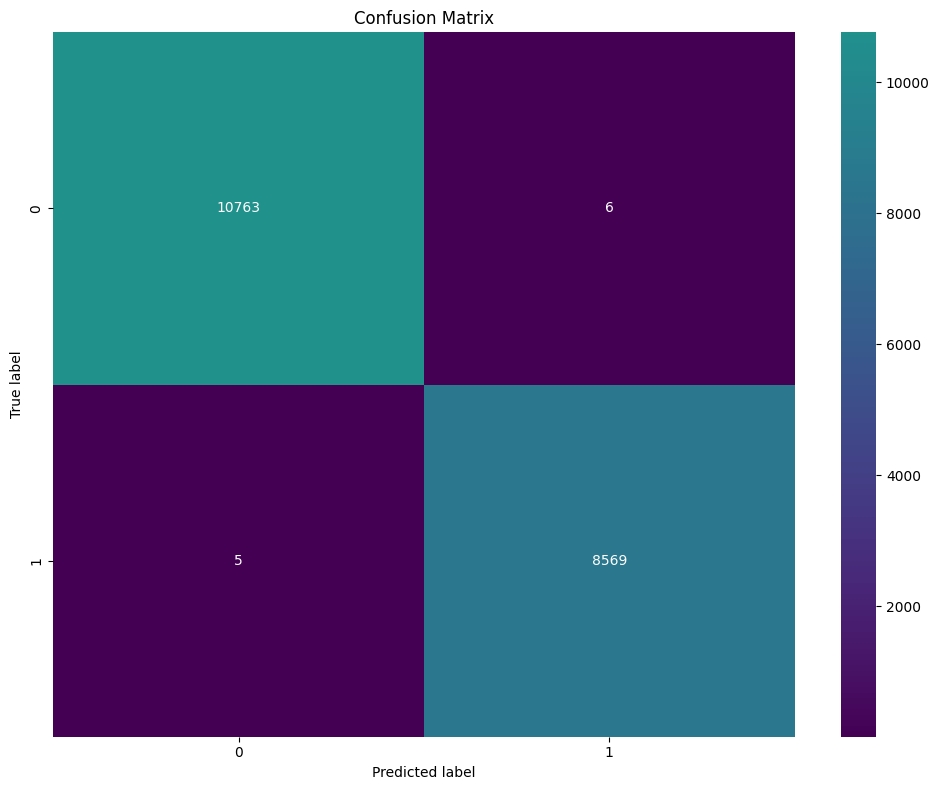

In [75]:
report, misclassified_images = evaluate_model_seaborn(test_dataset,y_true,y_preds)

In [76]:
report

{'accuracy': 0.9994313188233469,
 'f1_score': 0.9994313222015165,
 'matthews_corrcoef': np.float64(0.998847819720317),
 'classification_report': {'0': {'precision': 0.999535661218425,
   'recall': 0.9994428452038258,
   'f1-score': 0.9994892510563217,
   'support': 10769.0},
  '1': {'precision': 0.9993002915451895,
   'recall': 0.9994168416141824,
   'f1-score': 0.9993585631815266,
   'support': 8574.0},
  'accuracy': 0.9994313188233469,
  'macro avg': {'precision': 0.9994179763818072,
   'recall': 0.9994298434090041,
   'f1-score': 0.9994239071189241,
   'support': 19343.0},
  'weighted avg': {'precision': 0.9994313309915562,
   'recall': 0.9994313188233469,
   'f1-score': 0.9994313222015165,
   'support': 19343.0}}}

In [77]:
len(misclassified_images[0])

3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


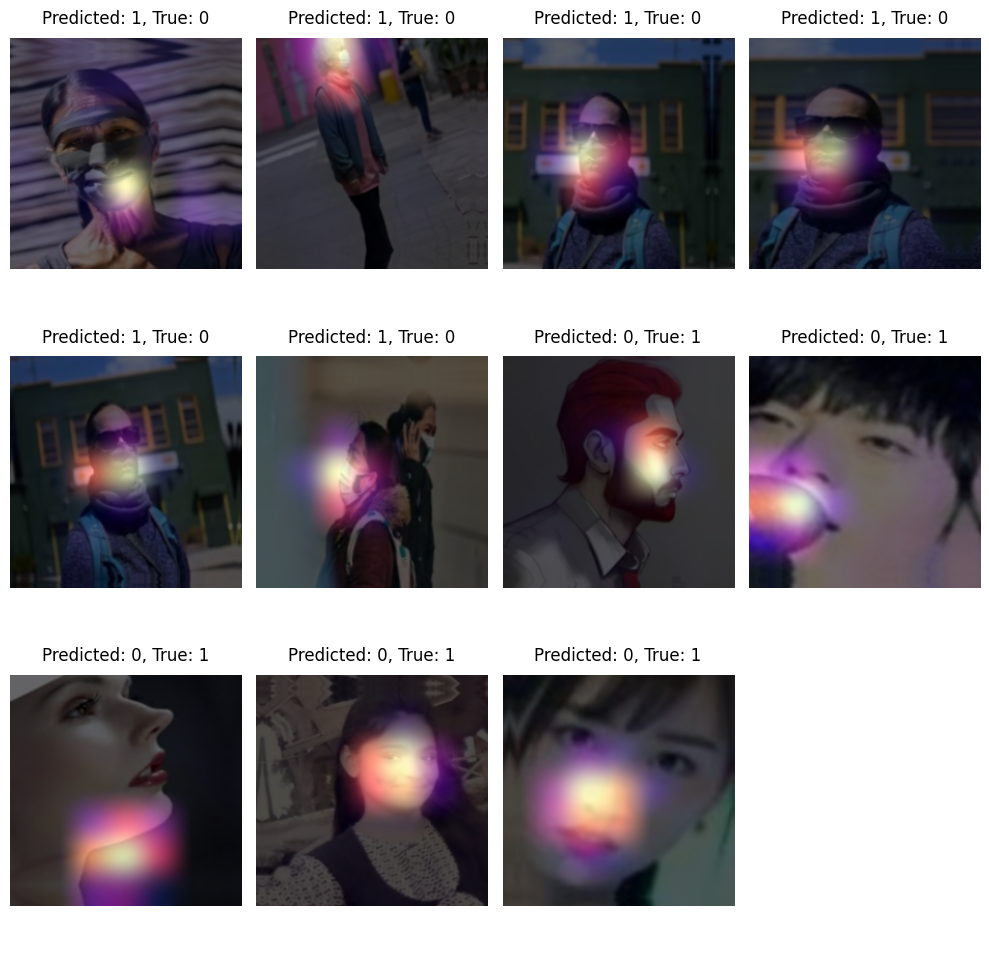

[]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


In [81]:
import numpy as np
final_images=[]
preds = []
labels = []
captions = []
for image in misclassified_images:
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=image[0],
                         )
    pred= np.argmax(enetb0_model.predict(image[0]),axis=1)
    #pred = enetb0_model.predict(image)
    preds.append(pred[0])
    final = superimpose_gradcam(heatmap=heatmap, img=image[0][0],alpha=2)
    final_images.append(final)
    captions.append(f"Predicted: {image[2]}, True: {image[1]}")
p=plot_images_grid(final_images,captions = captions)
print(labels)
print(preds)